# Acknowledgements

In [36]:
# Original idea and paper/blog from Ben Moseley
# https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

# Imports

In [37]:
from PIL import Image # import Pillow
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Custom Functions and Equation Setup

In [38]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """
    Helper function for saving GIFs.
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format="GIF", append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [39]:
def oscillator(d, w0, x):
    """
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem.

    The sin of the function is not used in demonstration.
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    # sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [40]:
class FCN(nn.Module):
    """
    Defines a fully connected neural network.
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Creating Training Data

In [41]:
d, w0 = 2, 20

# generate the full analytical solution
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

# extract every 20th point from the analytical solution
# effectively, we"re taking only a small sample of the data
x_data = x[0:200:20]
y_data = y[0:200:20]

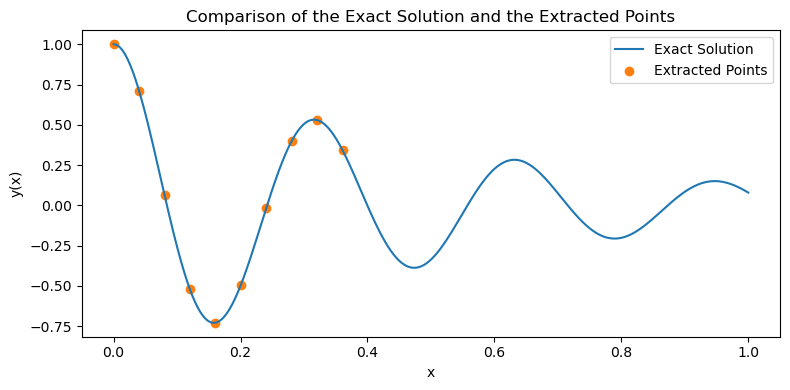

In [42]:
# visualize the data extraction
plt.figure(figsize=(8,4))
plt.title("Comparison of the Exact Solution and the Extracted Points")
plt.ylabel("y(x)")
plt.xlabel("x")
plt.plot(x, y, label="Exact Solution", color="tab:blue")
plt.scatter(x_data, y_data, color="tab:orange", label="Extracted Points")
plt.legend()

# saving the file to /images
plt.tight_layout()
filename = "Harmonic-TrainingData"
filepath = f"../images/{filename}.png"
plt.savefig(f"{filepath}")
plt.show()

# Training and Visualizing Model Performance

In [43]:
def plot_result(x, y, x_data, y_data, yh, tag, xp=None, color="tab:red"):
    """
    Plot given model"s performance. Title the plot with the given tag argument.
    """
    plt.figure(figsize=(8,4))
    plt.title(f"{tag} Modeling Performance")
    plt.ylabel("y(x)")
    plt.xlabel("x")
    plt.plot(x, y, color="tab:blue", linewidth=2, alpha=0.8, label="Exact Solution")
    plt.plot(x, yh, color=color, linewidth=4, alpha=0.8, label="Model Prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training Data")
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label="Physics Loss Training Locations")
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i"%(i+1), fontsize="xx-large", color="k")

In [44]:
random_seed = 123 # set random seed for modeling

### Traditional NN

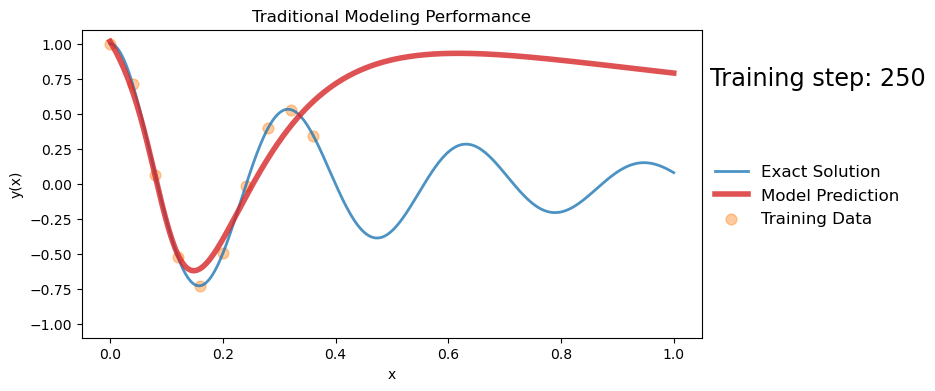

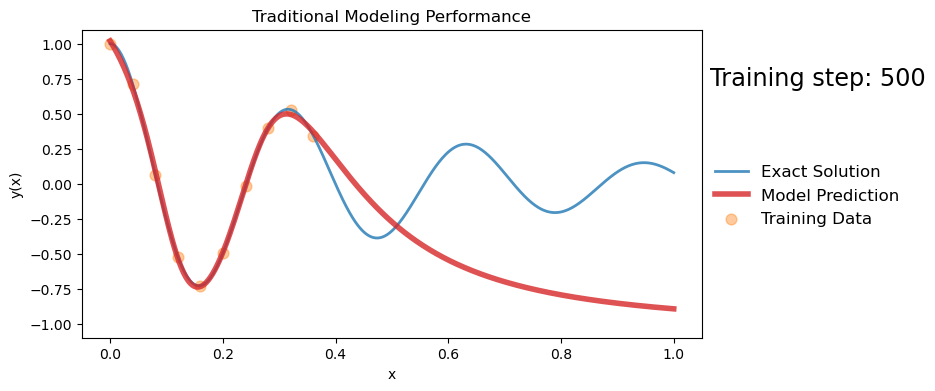

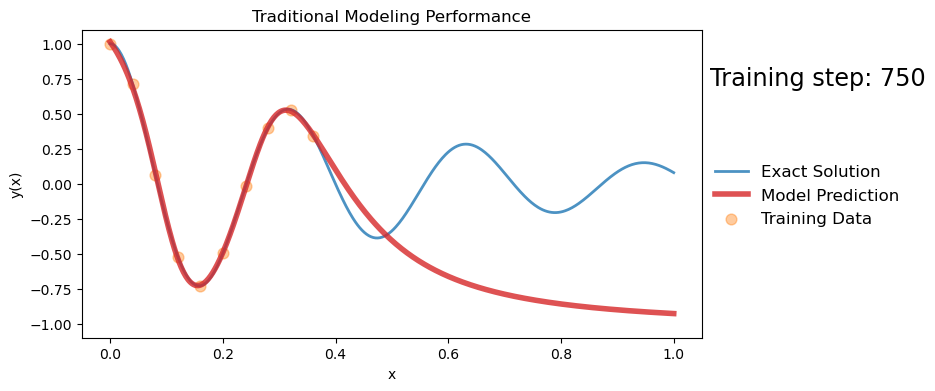

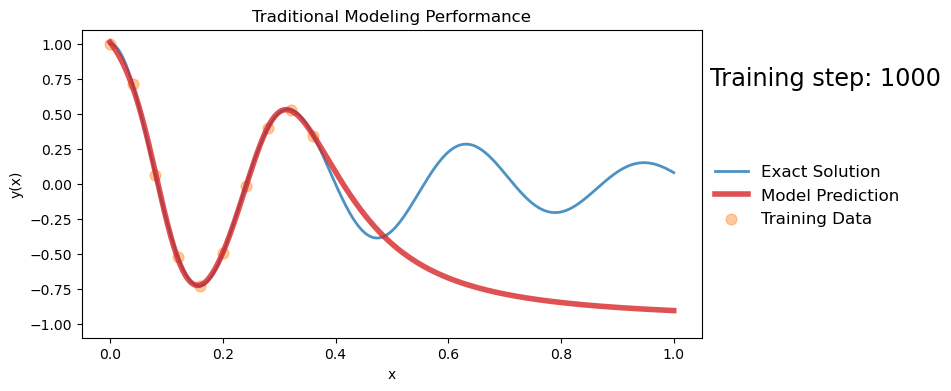

In [45]:
tag = "Traditional" # label graphs as traditional
nn_errors = []  # store NN errors
files = [] # store gif images

# create and setup traditional model
torch.manual_seed(random_seed)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(1000):
    # forward and backward pass on training data
    optimizer.zero_grad()
    y_nn = model(x_data)
    train_loss = torch.mean((y_nn - y_data)**2) # use mean squared error
    train_loss.backward()
    optimizer.step()

    # calculate actual loss
    y_nn = model(x).detach()
    actual_loss = torch.mean((y_nn - y)**2)
    nn_errors.append(actual_loss.item())
    
    # plot the result as training progresses
    if (i+1) % 25 == 0: 
        plot_result(x, y, x_data, y_data, y_nn, tag)
        filepath = "trad-plot/nn_%.8i.png"%(i+1)
        files.append(filepath)
        plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")

        if (i+1) % 250 == 0:
            plt.show()
        else: 
            plt.close("all")

# create GIF
filepath = "../images/NN.gif"
save_gif_PIL(filepath, files, fps=20, loop=0)

### PINNs

In [46]:
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True) # sample locations over the problem domain
mu, k = 2*d, w0**2

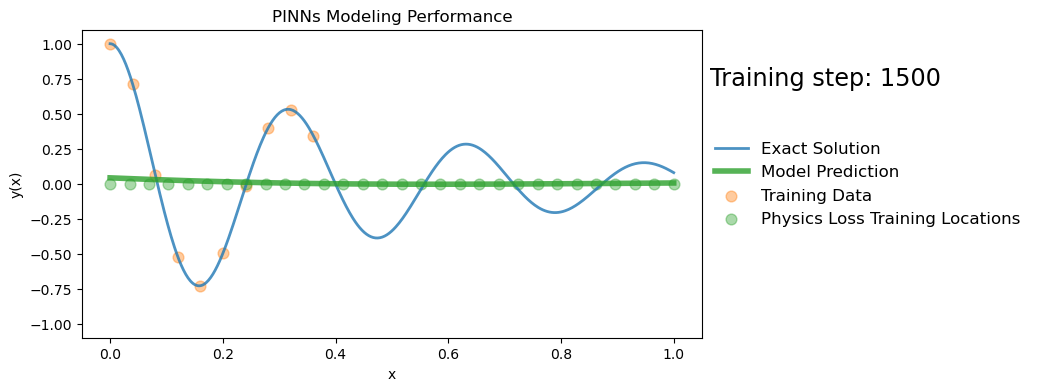

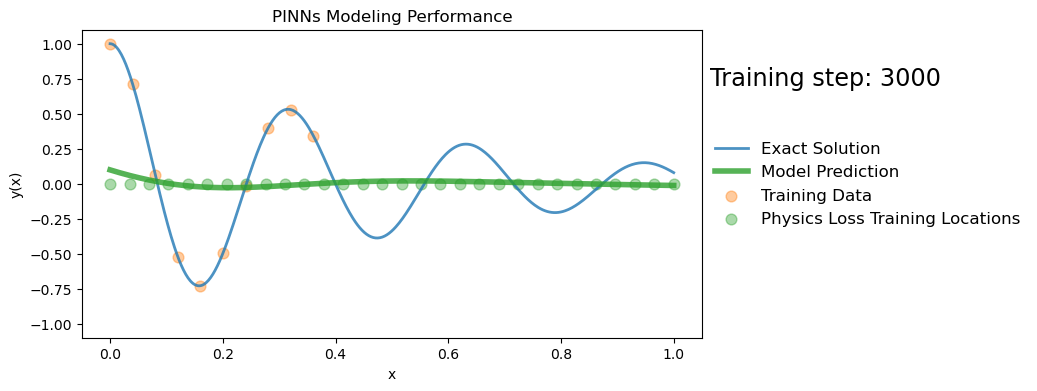

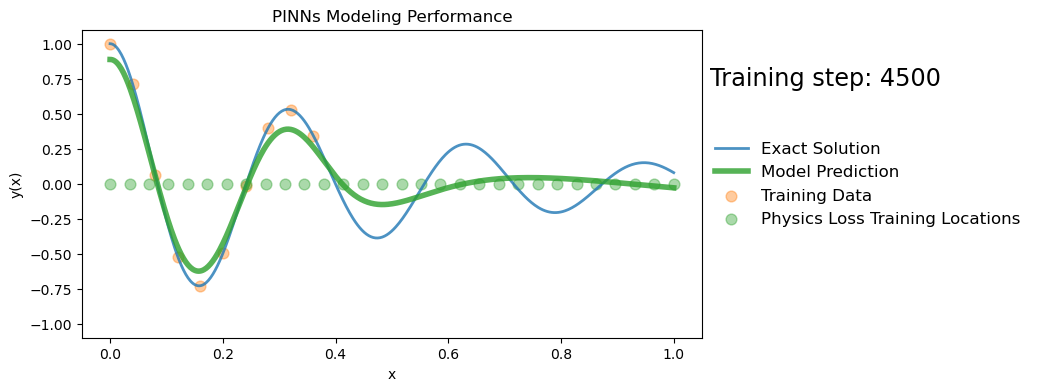

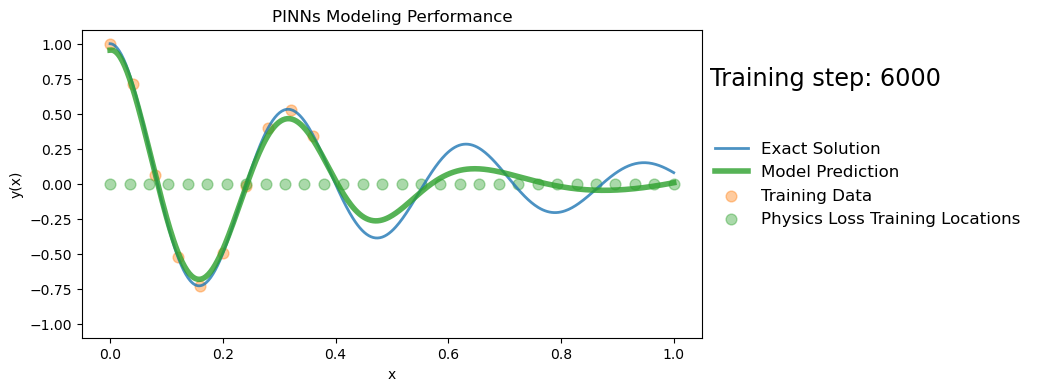

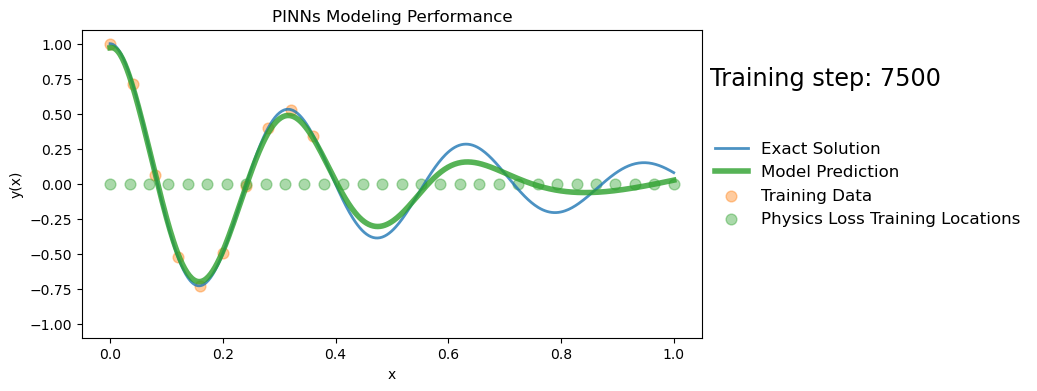

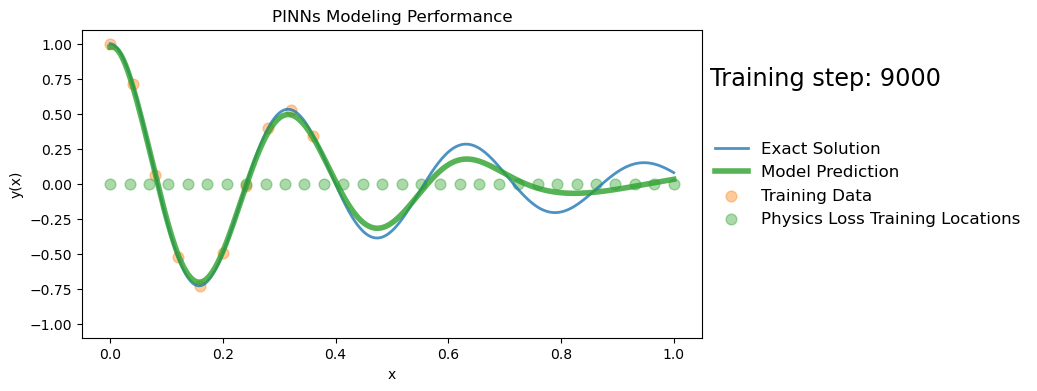

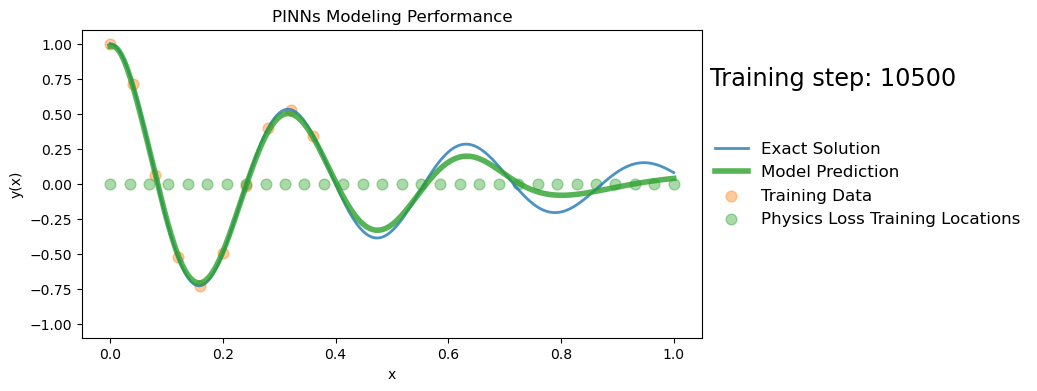

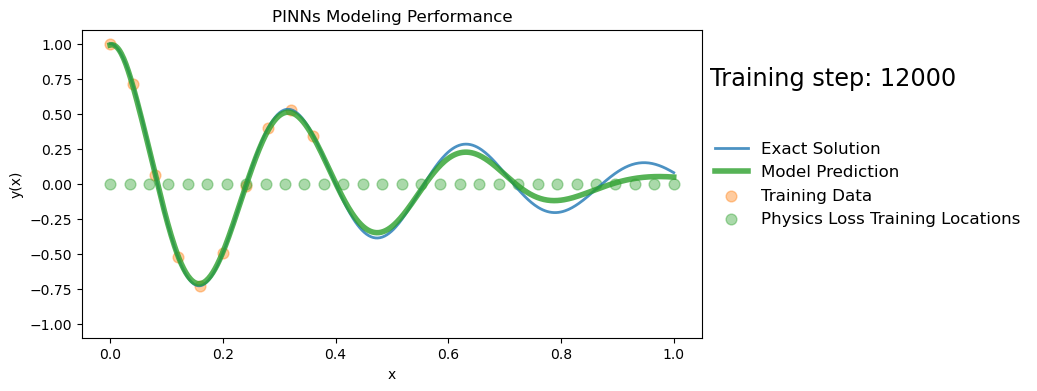

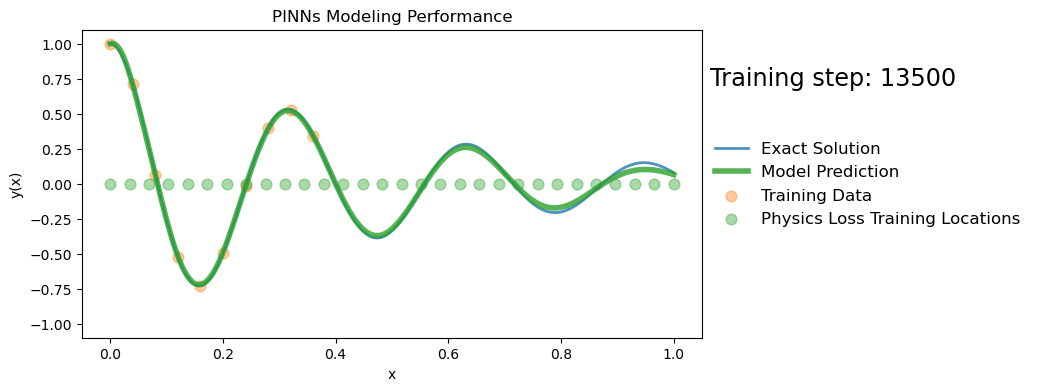

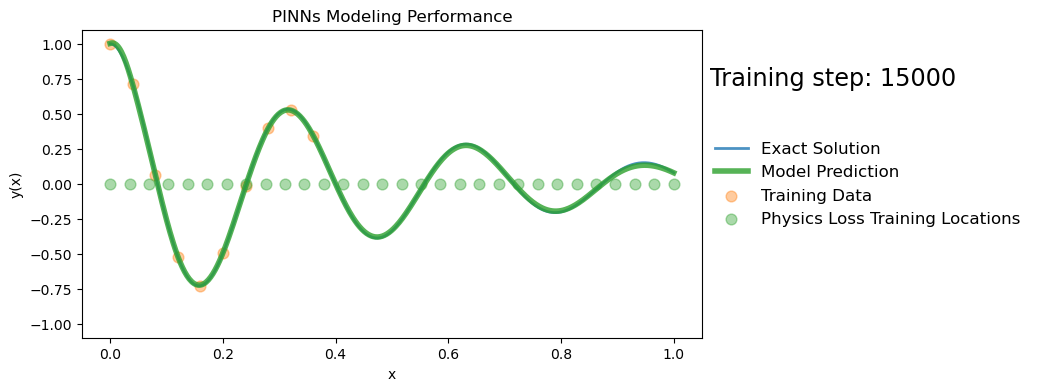

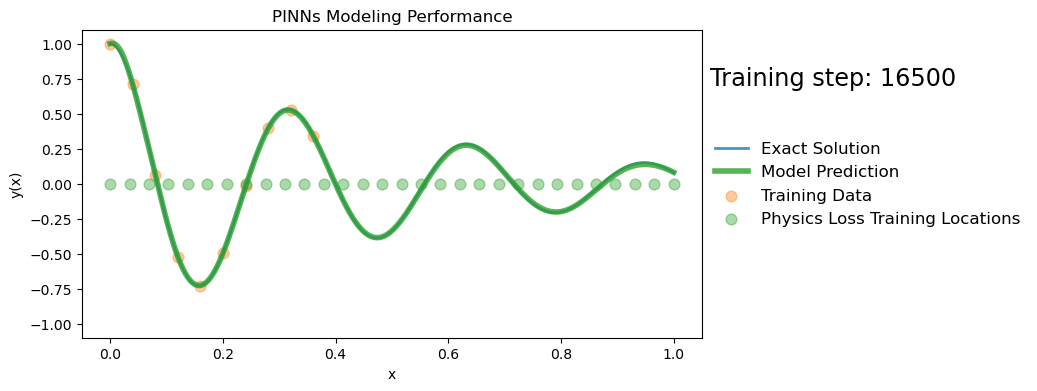

In [47]:
tag = "PINNs" # label graphs as PINNs
pinn_errors = [] # store PINN errors 
files = [] # store gif images

# create and setup PINN model
torch.manual_seed(random_seed)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(16500):
    # compute the "data loss" from the training data
    optimizer.zero_grad()
    y_pinn = model(x_data)
    loss1 = torch.mean((y_pinn-y_data)**2) # use mean squared error
    
    # compute the "physics loss" from ODE
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0] # computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()

    # calculate actual loss
    y_pinn = model(x).detach()
    actual_loss = torch.mean((y_pinn - y)**2)
    pinn_errors.append(actual_loss.item())
    
    # plot the result as training progresses
    if (i+1) % 500 == 0:
        xp = x_physics.detach()
        plot_result(x, y, x_data, y_data, y_pinn, tag, xp, color="tab:green")
        filepath = "pinns-plot/pinn_%.8i.png"%(i+1)
        files.append(filepath)
        plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")

        if (i+1) % 1500 == 0:
            plt.show()
        else: 
            plt.close("all")

# create GIF
filepath = "../images/PINN.gif"
save_gif_PIL(filepath, files, fps=20, loop=0)

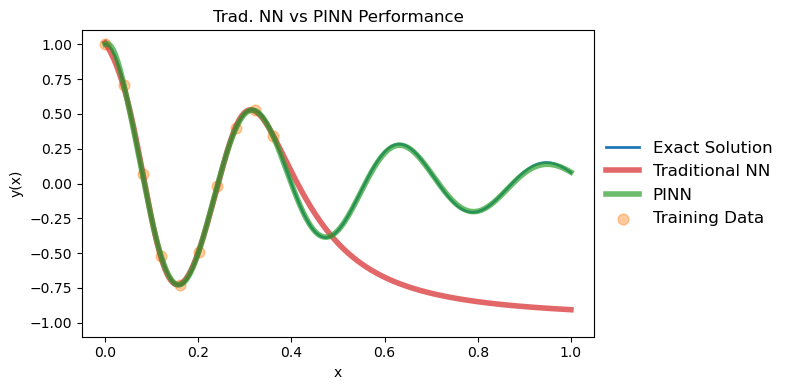

In [48]:
# Plotting Comparison
plt.figure(figsize=(8,4))
plt.title(f"Trad. NN vs PINN Performance")
plt.ylabel("y(x)")
plt.xlabel("x")
plt.plot(x, y, color="tab:blue", linewidth=2, alpha=1, label="Exact Solution")
plt.plot(x, y_nn, color="tab:red", linewidth=4, alpha=0.7, label="Traditional NN")
plt.plot(x, y_pinn, color="tab:green", linewidth=4, alpha=0.7, label="PINN")
plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training Data")
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.xlim(-0.05, 1.05)
plt.ylim(-1.1, 1.1)
plt.tight_layout()
filename = "Harmonic-FinalComparison"
plt.savefig(f"../images/{filename}.png")
plt.show()

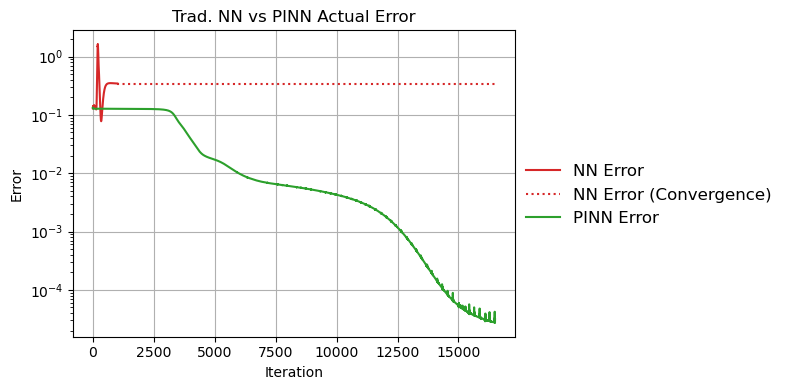

In [49]:
# Plotting errors
plt.figure(figsize=(8,4))
plt.title(f"Trad. NN vs PINN Actual Error")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.yscale("log")
plt.grid(True)
plt.plot(range(1, len(nn_errors) + 1), nn_errors, color="tab:red", label="NN Error")
plt.hlines(nn_errors[-1], len(nn_errors) + 1, len(pinn_errors) + 1, colors="tab:red", linestyles="dotted", label="NN Error (Convergence)")
plt.plot(range(1, len(pinn_errors) + 1), pinn_errors, color="tab:green", label="PINN Error")
l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.tight_layout()
filename = "Harmonic-ErrorComparison"
plt.savefig(f"../images/{filename}.png")
plt.show()